In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from lightgbm import LGBMRanker
from tqdm import tqdm


In real scenes, we don't get access to the whole dataset. Here we apply analysis to subset of data(eg. top songs from some years)

find features that are highly correlated to the 3rd party ranking and display them.

In [4]:
df = pd.read_csv('songs_normalize.csv')

In [5]:
df.info() 
is_NaN = df.isnull()
row_has_NaN = is_NaN.any(axis=1)
rows_with_NaN = df[row_has_NaN]
print(rows_with_NaN)
print(len(df))
df = df.drop_duplicates()
print("Length after drop duplicates :")
print(len(df))


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   artist            2000 non-null   object 
 1   song              2000 non-null   object 
 2   duration_ms       2000 non-null   int64  
 3   explicit          2000 non-null   bool   
 4   year              2000 non-null   int64  
 5   popularity        2000 non-null   int64  
 6   danceability      2000 non-null   float64
 7   energy            2000 non-null   float64
 8   key               2000 non-null   int64  
 9   loudness          2000 non-null   float64
 10  mode              2000 non-null   int64  
 11  speechiness       2000 non-null   float64
 12  acousticness      2000 non-null   float64
 13  instrumentalness  2000 non-null   float64
 14  liveness          2000 non-null   float64
 15  valence           2000 non-null   float64
 16  tempo             2000 non-null   float64


In [6]:
df.describe()

,duration_ms,year,popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo
count,1941.000000,1941.000000,1941.000000,1941.000000,1941.000000,1941.000000,1941.000000,1941.000000,1941.000000,1941.000000,1941.000000,1941.000000,1941.000000,1941.000000
mean,228594.973725,2009.520350,59.633179,0.667814,0.721549,5.369397,-5.514082,0.553323,0.103783,0.128173,0.015372,0.181726,0.552966,120.158442
std,39249.796103,5.875532,21.501053,0.140608,0.152872,3.615270,1.938950,0.497277,0.096148,0.172584,0.088371,0.140910,0.220845,26.990475
min,113000.000000,1998.000000,0.000000,0.129000,0.054900,0.000000,-20.514000,0.000000,0.023200,0.000019,0.000000,0.021500,0.038100,60.019000
25%,203506.000000,2004.000000,56.000000,0.581000,0.624000,2.000000,-6.490000,0.000000,0.039700,0.013500,0.000000,0.088400,0.390000,98.986000
50%,223186.000000,2010.000000,65.000000,0.676000,0.739000,6.000000,-5.285000,1.000000,0.061000,0.055800,0.000000,0.124000,0.560000,120.028000
75%,247946.000000,2015.000000,73.000000,0.765000,0.840000,8.000000,-4.168000,1.000000,0.129000,0.176000,0.000069,0.242000,0.731000,134.199000
max,484146.000000,2020.000000,89.000000,0.975000,0.999000,11.000000,-0.276000,1.000000,0.576000,0.976000,0.985000,0.853000,0.973000,210.851000


<AxesSubplot:xlabel='year', ylabel='count'>

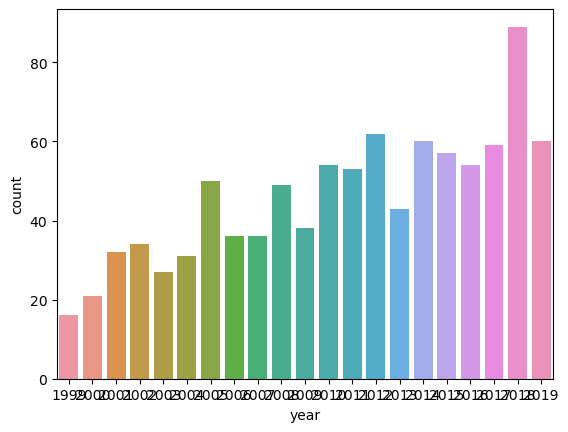

In [7]:
df_popular = df.loc[(df.popularity>65)]
sns.countplot(x='year', data=df_popular)


In [8]:
df_popular

,artist,song,duration_ms,explicit,year,popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,genre
0,Britney Spears,Oops!...I Did It Again,211160,False,2000,77,0.751,0.834,1,-5.444,0,0.0437,0.3000,0.000018,0.3550,0.894,95.053,pop
1,blink-182,All The Small Things,167066,False,1999,79,0.434,0.897,0,-4.918,1,0.0488,0.0103,0.000000,0.6120,0.684,148.726,"rock, pop"
2,Faith Hill,Breathe,250546,False,1999,66,0.529,0.496,7,-9.007,1,0.0290,0.1730,0.000000,0.2510,0.278,136.859,"pop, country"
3,Bon Jovi,It's My Life,224493,False,2000,78,0.551,0.913,0,-4.063,0,0.0466,0.0263,0.000013,0.3470,0.544,119.992,"rock, metal"
5,Sisqo,Thong Song,253733,True,1999,69,0.706,0.888,2,-6.959,1,0.0654,0.1190,0.000096,0.0700,0.714,121.549,"hip hop, pop, R&B"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,Jonas Brothers,Sucker,181026,False,2019,79,0.842,0.734,1,-5.065,0,0.0588,0.0427,0.000000,0.1060,0.952,137.958,pop
1996,Taylor Swift,Cruel Summer,178426,False,2019,78,0.552,0.702,9,-5.707,1,0.1570,0.1170,0.000021,0.1050,0.564,169.994,pop
1997,Blanco Brown,The Git Up,200593,False,2019,69,0.847,0.678,9,-8.635,1,0.1090,0.0669,0.000000,0.2740,0.811,97.984,"hip hop, country"
1998,Sam Smith,Dancing With A Stranger (with Normani),171029,False,2019,75,0.741,0.520,8,-7.513,1,0.0656,0.4500,0.000002,0.2220,0.347,102.998,pop


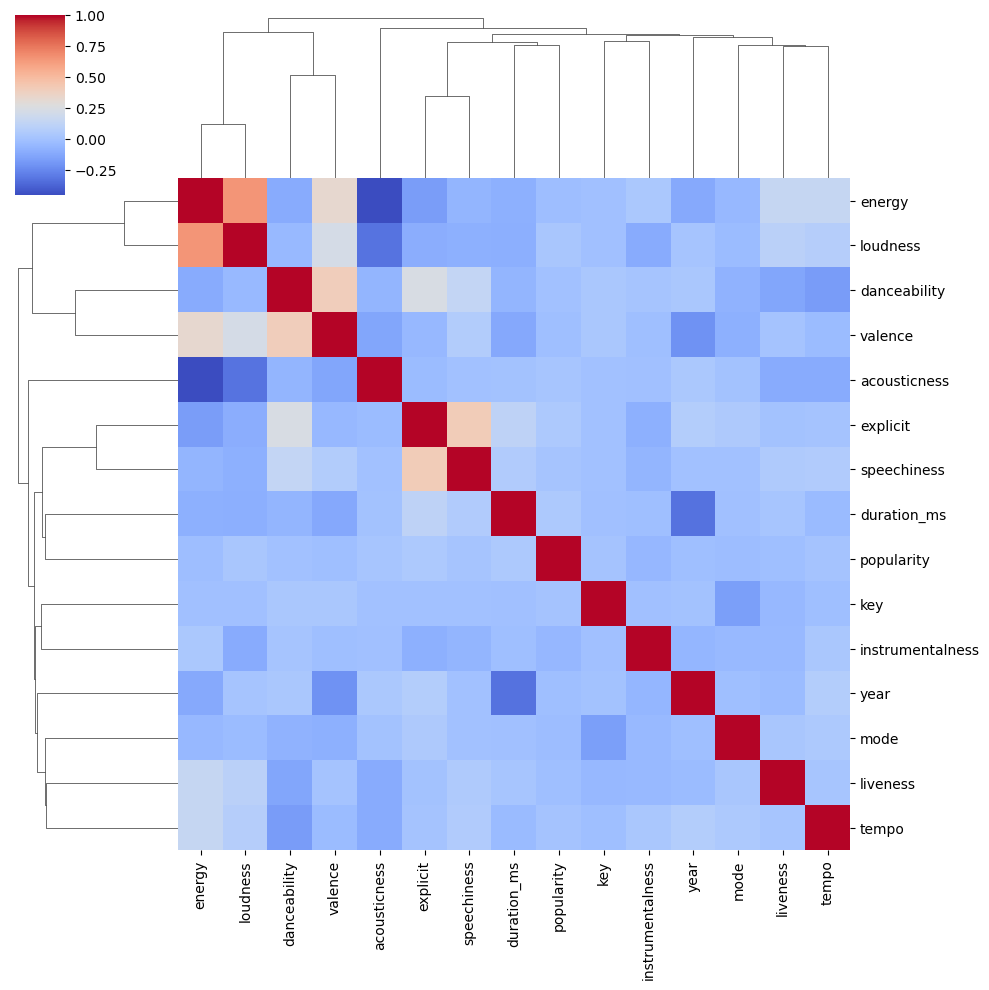

In [9]:
sns.clustermap(df.corr(),cmap='coolwarm')


In [10]:
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
df_num = df.select_dtypes(include=numerics)

In [11]:
df_num.columns

Index(['duration_ms', 'year', 'popularity', 'danceability', 'energy', 'key',
       'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness',
       'liveness', 'valence', 'tempo'],
      dtype='object')

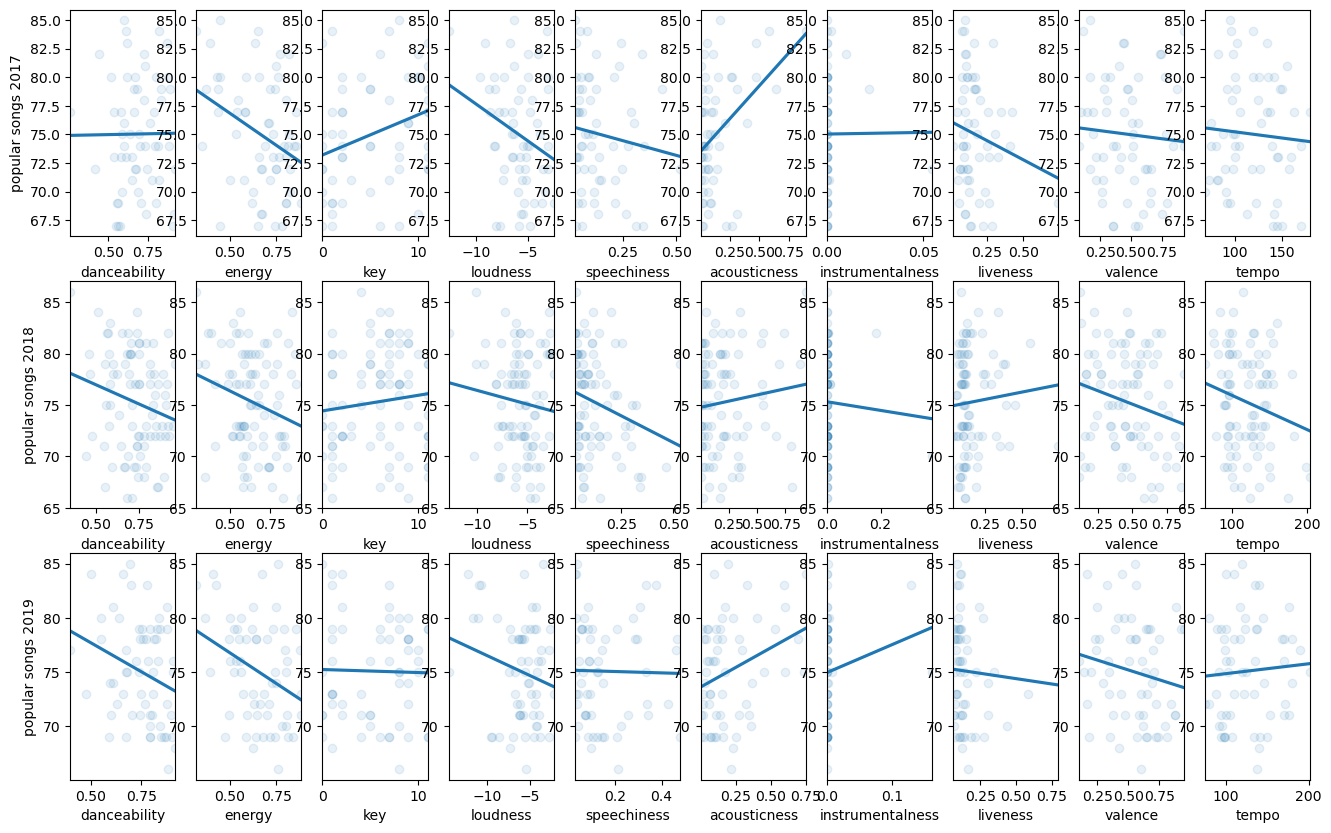

In [12]:
start = 2017
years = 3
cols = ['danceability', 'energy', 'key',
       'loudness', 'speechiness', 'acousticness', 'instrumentalness',
       'liveness', 'valence', 'tempo']
features = len(cols)
df_popular_num = df_popular[cols]

fig, axes = plt.subplots(years, features,figsize=(16,10))

for i in range(years): #year
    
    
    for j in range(features):
        axes[i][j].set_xlabel(df_popular_num.columns[j])
        sns.regplot (x=df_popular_num.loc[(df_popular.year==start+i)].iloc[:,j],
                     y=df_popular.loc[(df_popular.year==start+i)].popularity, 
                     ax = axes[i][j],
                     ci=None,
                     scatter_kws={"alpha":0.1})
        axes[i][j].set_ylabel('')
    axes[i][0].set_ylabel(f'popular songs {start+i}')  


No handles with labels found to put in legend.


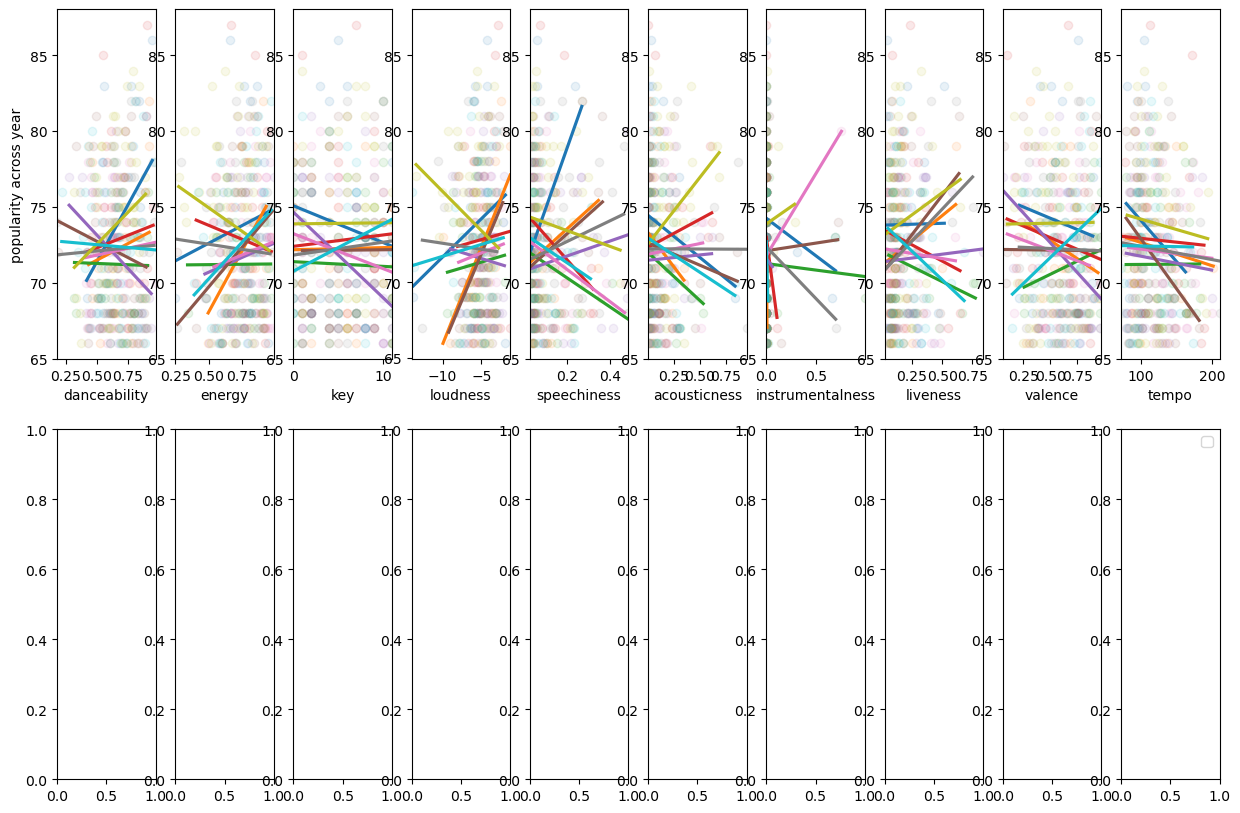

In [13]:


fig, axes = plt.subplots(2, features,figsize=(15,10))

for i in range(1): 
       
    for j in range(features):
        axes[i][j].set_xlabel(df_popular_num.columns[j])
        
        for k in range(10):
            sns.regplot (x=df_popular_num.loc[(df_popular.year==df_popular.year.unique()[k])].iloc[:,j],
                         y=df_popular.loc[(df_popular.year==df_popular.year.unique()[k])].popularity,
                         ax = axes[i][j],
                         ci=None,
                         label=df_popular.year.unique()[k],
                         scatter_kws={"alpha":0.1})
        axes[i][j].set_ylabel('')
    axes[i][0].set_ylabel(f'popularity across year')  
    
plt.legend(loc=0)


In [14]:
import io
import os
import sys
import json
import django

import plotly.graph_objs as go
import plotly.offline as offline
from plotly.offline import plot
offline.init_notebook_mode(connected=True)

BDIR = os.path.abspath(os.path.join(sys.argv[0], '../../../..'))

# run this file in project floder
sys.path.insert(0, '../../../xai/')

# need this to run django models
os.environ.setdefault('DJANGO_SETTINGS_MODULE', 'xai_demo.settings')
os.environ["DJANGO_ALLOW_ASYNC_UNSAFE"] = "true"

django.setup()


In [15]:
from xai_backend.services import sample_ranking

songs = sample_ranking().content

df_songs = pd.DataFrame(json.loads(songs))


Instead get rankings from the backend, loads rankings from files

In [16]:
# df_songs = pd.DataFrame(json.load(open('song1.json')))
# df_songs = pd.DataFrame(json.load(open('song2.json')))
# df_songs = pd.DataFrame(json.load(open('song3.json')))

In [17]:
cols = ['acousticness', 'danceability', 'energy',
        'instrumentalness', 'key', 'liveness',
       'loudness', 'popularity', 'rank', 'score',
       'speechiness', 'tempo', 'valence']

df_songs_num = df_songs[cols]

In [18]:
import plotly.figure_factory as ff
fig = ff.create_scatterplotmatrix(df_songs_num, diag='box', index='rank',colormap='Portland',
                                  colormap_type='cat',
                                  height=1600, width=1600)
fig.show()

In [19]:
import plotly.express as px


corr = df_songs_num.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
df_mask = corr.mask(mask)

fig = ff.create_annotated_heatmap(z=df_mask.round(2).to_numpy(), 
                                  x=df_mask.columns.tolist(),
                                  y=df_mask.columns.tolist(),
                                  colorscale=px.colors.diverging.RdBu,
                                  hoverinfo="none", #Shows hoverinfo for null values
                                  showscale=True, ygap=1, xgap=1
                                 )

fig.update_xaxes(side="bottom")

fig.update_layout(
    title_text='Heatmap', 
    title_x=0.5, 
    width=1000, 
    height=1000,
    xaxis_showgrid=False,
    yaxis_showgrid=False,
    xaxis_zeroline=False,
    yaxis_zeroline=False,
    yaxis_autorange='reversed',
    template='plotly_white',
)


In [20]:
most_corr = corr.reindex(corr['score'].abs().sort_values()[::-1].index)

In [21]:
df_songs_num[most_corr.index[1]]

0    0.78400
1    0.20100
2    0.12200
3    0.08430
4    0.03750
5    0.16200
6    0.00627
7    0.00144
8    0.00673
9    0.03840
Name: acousticness, dtype: float64

In [22]:
df_songs

,acousticness,artist,danceability,duration_ms,energy,explicit,genre,id,instrumentalness,key,...,mode,name,popularity,rank,score,song,speechiness,tempo,valence,year
0,0.78400,Westlife,0.272,219106.0,0.203,0.0,pop,665.0,0.000000,9.0,...,1.0,The Rose,0.0,1.0,0.199952,The Rose,0.0294,109.581,0.172,2006.0
1,0.20100,Justin Timberlake,0.892,267266.0,0.714,0.0,pop,324.0,0.000234,4.0,...,0.0,Rock Your Body,76.0,2.0,0.120631,Rock Your Body,0.1410,100.972,0.817,2002.0
2,0.12200,Justin Timberlake,0.687,448573.0,0.723,0.0,pop,688.0,0.001020,7.0,...,1.0,What Goes Around.../...Comes Around (Interlude),70.0,3.0,0.118868,What Goes Around.../...Comes Around (Interlude),0.0709,76.000,0.432,2006.0
3,0.08430,Kesha,0.752,172053.0,0.836,1.0,"pop, Dance/Electronic",1027.0,0.000425,10.0,...,1.0,Blah Blah Blah (feat. 3OH!3),61.0,4.0,0.108515,Blah Blah Blah (feat. 3OH!3),0.1150,120.003,0.519,2010.0
4,0.03750,Major Lazer,0.746,166138.0,0.877,0.0,"hip hop, pop, Dance/Electronic",1485.0,0.000833,9.0,...,0.0,Light It Up (feat. Nyla & Fuse ODG) - Remix,49.0,5.0,0.090300,Light It Up (feat. Nyla & Fuse ODG) - Remix,0.0666,107.985,0.751,2015.0
5,0.16200,Lorde,0.691,193058.0,0.582,0.0,"pop, Dance/Electronic",1299.0,0.000000,6.0,...,1.0,Team,0.0,6.0,0.087507,Team,0.0939,100.050,0.427,2013.0
6,0.00627,Olly Murs,0.512,206373.0,0.828,0.0,"pop, Dance/Electronic",1325.0,0.000009,11.0,...,0.0,Dear Darlin',59.0,7.0,0.073764,Dear Darlin',0.0454,124.021,0.340,2012.0
7,0.00144,P!nk,0.674,247906.0,0.628,0.0,pop,1221.0,0.000000,2.0,...,1.0,Try,76.0,8.0,0.069298,Try,0.0300,103.998,0.552,2012.0
8,0.00673,Kaiser Chiefs,0.451,204200.0,0.939,0.0,rock,755.0,0.000005,5.0,...,0.0,Ruby,67.0,9.0,0.066007,Ruby,0.0512,93.416,0.448,2007.0
9,0.03840,Rich Homie Quan,0.676,176674.0,0.615,1.0,"hip hop, pop",1539.0,0.000000,6.0,...,0.0,"Flex (Ooh, Ooh, Ooh)",1.0,10.0,0.065159,"Flex (Ooh, Ooh, Ooh)",0.0496,163.993,0.883,2015.0


In [23]:
# create trace 1 that is 3d scatter
trace1 = go.Scatter3d(
    x=df_songs_num['rank'],
    y=df_songs_num[most_corr.index[1]],
    z=df_songs_num[most_corr.index[2]],
    mode='markers',
    marker=dict(
        size=12,
        # color=z,                # set color to an array/list of desired values
        colorscale='Viridis',   # choose a colorscale
        opacity=0.8
    ),
    )
data = [trace1]
layout = go.Layout(
    margin=dict(
        l=0,
        r=0,
        b=0,
        t=0),
        scene = dict(
        xaxis = dict(
            title='rank'),
        yaxis = dict(
            title=most_corr.index[1]),
        zaxis = dict(
            title=most_corr.index[2])
        )
)
fig = go.Figure(data=data, layout=layout)
fig.show()

In [24]:
df_songs_norm=(df_songs_num-df.min())/(df_songs_num.max()-df.min())

trace1 = go.Bar(
                x = df_songs['song'],
                y = df_songs_norm[most_corr.index[1]] * np.sign(most_corr['rank'][1]),
                name = most_corr.index[1],
                marker = dict(color = 'rgba(255, 174, 255, 0.5)',
                             line=dict(color='rgb(0,0,0)',width=1.5)),
                text = df_songs['rank'])
# create trace2 
trace2 = go.Bar(
                x = df_songs['song'],
                y = df_songs_norm[most_corr.index[2]] * np.sign(most_corr['rank'][2]),
                name = most_corr.index[2],
                marker = dict(color = 'rgba(255, 255, 128, 0.5)',
                              line=dict(color='rgb(0,0,0)',width=1.5)),
                text = df_songs['rank'])

trace3 = go.Bar(
                x = df_songs['song'],
                y = df_songs_norm[most_corr.index[3]] * np.sign(most_corr['rank'][3]),
                name = most_corr.index[3],
                marker = dict(color = 'rgba(128, 255, 200, 0.5)',
                              line=dict(color='rgb(0,0,0)',width=1.5)),
                text = df_songs['rank'])

data = [trace1, trace2, trace3]
layout = go.Layout(barmode = "group")
fig = go.Figure(data = data, layout = layout)
fig.show()

In [25]:
from sklearn.cluster import KMeans

mask = [n for n in cols if n != 'rank' and n != 'score']

cluster_num = 7
kmeans = KMeans(n_clusters=cluster_num, random_state=20).fit(df[mask])
kmeans.labels_

array([6, 2, 2, ..., 6, 6, 0])

In [26]:
kmeans.predict(df_songs_num[mask])

array([1, 6, 6, 0, 3, 1, 0, 6, 6, 5])

In [27]:
df_songs_norm[df_songs_num.columns]


,acousticness,danceability,energy,instrumentalness,key,liveness,loudness,popularity,rank,score,speechiness,tempo,valence
0,1.0,0.187418,0.167515,0.0,0.818182,0.106981,0.610829,0.0,NaN,NaN,0.052632,0.476677,0.15848
1,0.256359,1.0,0.745504,0.229412,0.363636,0.055485,0.81717,1.0,NaN,NaN,1.0,0.393877,0.921884
2,0.155592,0.731324,0.755684,1.0,0.636364,1.0,0.890867,0.921053,NaN,NaN,0.404924,0.153702,0.466209
3,0.107504,0.816514,0.883497,0.416667,0.909091,0.729828,0.98005,0.802632,NaN,NaN,0.779287,0.576913,0.56918
4,0.047808,0.80865,0.929872,0.816667,0.818182,0.3835,0.945631,0.644737,NaN,NaN,0.368421,0.461327,0.843768
5,0.206613,0.736566,0.5962,0.0,0.545455,0.408885,0.738668,0.0,NaN,NaN,0.60017,0.38501,0.460291
6,0.007973,0.501966,0.874449,0.008559,1.0,0.176791,0.895332,0.776316,NaN,NaN,0.188455,0.615558,0.35732
7,0.001812,0.714286,0.64823,0.0,0.181818,0.132185,0.759297,1.0,NaN,NaN,0.057725,0.422981,0.608238
8,0.00856,0.422018,1.0,0.004755,0.454545,0.10136,1.0,0.881579,NaN,NaN,0.237691,0.321205,0.485146
9,0.048956,0.716907,0.633526,0.0,0.545455,0.579329,0.733582,0.013158,NaN,NaN,0.224109,1.0,1.0


In [28]:
rank1 = 1
rank2 = 10

x1 = df_songs_norm[df_songs_num.columns].iloc[rank1-1]
x2 = df_songs_norm[df_songs_num.columns].iloc[rank2-1]

trace1 = go.Bar(
                x = df_songs_num.columns,
                y = x1,
                name = rank1,
                marker = dict(color = 'rgba(255, 174, 255, 0.5)',
                             line=dict(color='rgb(0,0,0)',width=1.5)),
                )
# create trace2 
trace2 = go.Bar(
                x = df_songs_num.columns,
                y = x2,
                name = rank2,
                marker = dict(color = 'rgba(255, 255, 128, 0.5)',
                              line=dict(color='rgb(0,0,0)',width=1.5)),
                )
data = [trace1, trace2]
layout = go.Layout(barmode = "group")
fig = go.Figure(data = data, layout = layout)
fig.show()

Rank is the smaller the better!

In [29]:
mask = [n for n in cols if n != 'rank' and n != 'score']

cat = kmeans.predict(df_songs_num[mask])

colors = ['rgba(255, 174, 255, 0.5)', 'rgba(255, 255, 128, 0.5)', 'rgba(128, 255, 200, 0.5)',
    'rgba(199, 174, 255, 0.5)', 'rgba(39, 140, 255, 0.5)', 'rgba(255, 122, 133, 0.5)', 'rgba(55, 174, 99, 0.5)',
    'rgba(140, 100, 255, 0.5)', 'rgba(80, 150, 74, 0.5)', 'rgba(255, 255, 255, 0.5)', 'rgba(255, 174, 0, 0.5)'
]


res = []
for rank in range(10):
    res.append(
        go.Bar(
            x=df_songs_num.columns,
            y=df_songs_norm[df_songs_num.columns].iloc[rank],
            name=rank,
            marker = dict(color = colors[cat[rank]],
                             line=dict(color='rgb(0,0,0)',width=1.5)),
        )
    )

layout = go.Layout(
    barmode='overlay'
)
print('click on the right to display selectively. If 2 songs are from the same cluster(color) but they differ much in rank, compare their features. \
Features that differ much could be the explanation.')
fig = go.Figure(data=res, layout=layout)
fig.show()

click on the right to display selectively. If 2 songs are from the same cluster(color) but they differ much in rank, compare their features. Features that differ much could be the explanation.


In [31]:
mask = [n for n in cols if n != 'rank' and n != 'score']

cat = kmeans.predict(df_songs_num[mask])

colors = ['rgba(255, 174, 255, 1)', 'rgba(255, 255, 128, 1)', 'rgba(128, 255, 200, 1)',
    'rgba(199, 174, 255, 1)', 'rgba(39, 140, 255, 1)', 'rgba(255, 122, 133, 1)', 'rgba(55, 174, 99, 1)',
    'rgba(140, 100, 255, 1)', 'rgba(80, 150, 74, 1)', 'rgba(255, 255, 255, 1)', 'rgba(255, 174, 0, 1)'
]


res = []
for rank in range(10):
    res.append(
        go.Scatter3d(
            x=[df_songs_num[most_corr.index[0]][rank]],
    y=[df_songs_num[most_corr.index[1]][rank]],
    z=[df_songs_num[most_corr.index[2]][rank]],
    mode='markers',
    marker=dict(
        size=12,
        color=colors[cat[rank]],                # set color to an array/list of desired values
        # colorscale='Viridis',   # choose a colorscale
        opacity=0.8
            ),
        )
    )

layout = go.Layout(
    barmode='group',
    margin=dict(
        l=0,
        r=0,
        b=0,
        t=0),
        scene = dict(
        xaxis = dict(
            title=most_corr.index[0]),
        yaxis = dict(
            title=most_corr.index[1]),
        zaxis = dict(
            title=most_corr.index[2])
        )
)

fig = go.Figure(data=res, layout=layout)
fig.show()

In [ ]:
# plot HTML on browser
# plot(fig)

In [90]:
df

,artist,song,duration_ms,explicit,year,popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,genre
0,Britney Spears,Oops!...I Did It Again,211160,False,2000,77,0.751,0.834,1,-5.444,0,0.0437,0.3000,0.000018,0.3550,0.894,95.053,pop
1,blink-182,All The Small Things,167066,False,1999,79,0.434,0.897,0,-4.918,1,0.0488,0.0103,0.000000,0.6120,0.684,148.726,"rock, pop"
2,Faith Hill,Breathe,250546,False,1999,66,0.529,0.496,7,-9.007,1,0.0290,0.1730,0.000000,0.2510,0.278,136.859,"pop, country"
3,Bon Jovi,It's My Life,224493,False,2000,78,0.551,0.913,0,-4.063,0,0.0466,0.0263,0.000013,0.3470,0.544,119.992,"rock, metal"
4,*NSYNC,Bye Bye Bye,200560,False,2000,65,0.614,0.928,8,-4.806,0,0.0516,0.0408,0.001040,0.0845,0.879,172.656,pop
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,Jonas Brothers,Sucker,181026,False,2019,79,0.842,0.734,1,-5.065,0,0.0588,0.0427,0.000000,0.1060,0.952,137.958,pop
1996,Taylor Swift,Cruel Summer,178426,False,2019,78,0.552,0.702,9,-5.707,1,0.1570,0.1170,0.000021,0.1050,0.564,169.994,pop
1997,Blanco Brown,The Git Up,200593,False,2019,69,0.847,0.678,9,-8.635,1,0.1090,0.0669,0.000000,0.2740,0.811,97.984,"hip hop, country"
1998,Sam Smith,Dancing With A Stranger (with Normani),171029,False,2019,75,0.741,0.520,8,-7.513,1,0.0656,0.4500,0.000002,0.2220,0.347,102.998,pop


In [106]:
wd = pd.read_csv('../../data/world_daily.csv')

In [228]:
wd

,Position,Track Name,Artist,Streams,URL,Date,Region
0,1,Reggaetón Lento (Bailemos),CNCO,19272,https://open.spotify.com/track/3AEZUABDXNtecAO...,2017-01-01,ec
1,2,Chantaje,Shakira,19270,https://open.spotify.com/track/6mICuAdrwEjh6Y6...,2017-01-01,ec
2,3,Otra Vez (feat. J Balvin),Zion & Lennox,15761,https://open.spotify.com/track/3QwBODjSEzelZyV...,2017-01-01,ec
3,4,Vente Pa' Ca,Ricky Martin,14954,https://open.spotify.com/track/7DM4BPaS7uofFul...,2017-01-01,ec
4,5,Safari,J Balvin,14269,https://open.spotify.com/track/6rQSrBHf7HlZjtc...,2017-01-01,ec
...,...,...,...,...,...,...,...
3441192,196,More Than You Know,Axwell /\ Ingrosso,2126,https://open.spotify.com/track/71bBFbfn2OBK5Qw...,2018-01-09,hk
3441193,197,Issues,Julia Michaels,2117,https://open.spotify.com/track/7vu0JkJh0ldukEY...,2018-01-09,hk
3441194,198,Tuo Fei Lun,Eason Chan,2112,https://open.spotify.com/track/0pmGleExiQyd0Hx...,2018-01-09,hk
3441195,199,面具,Alfred Hui,2102,https://open.spotify.com/track/58SUsgamkW6vFFq...,2018-01-09,hk


In [118]:
merge = pd.merge(wd.rename(columns={'Track Name': 'song', 'Artist': 'artist'}), right=df, how='right', on=['song', 'artist'])
ch = merge[merge.Region=='ch']

In [82]:
rank_data = pd.merge(wd.rename(columns={'Track Name': 'song'}), right=df, how='right', on='song').dropna().drop_duplicates(subset=['song', 'Date', 'Position'])

In [138]:
ch_sorted = ch.copy()
ch_sorted['Position'] = ch.dropna().groupby("Date")["Position"].rank("dense", ascending=False).astype(int)
ch_data = ch_sorted.sort_values(['Date', 'Position'])
ch_data

,Position,song,artist,Streams,URL,Date,Region,duration_ms,explicit,year,...,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,genre
858249,1,Bounce Back,Big Sean,1892.0,https://open.spotify.com/track/0SGkqnVQo9KPytS...,2017-01-01,ch,222360,True,2017,...,1,-5.628,0,0.1390,0.106000,0.000000,0.1290,0.273,81.502,"hip hop, pop"
23593,2,Feel So Close - Radio Edit,Calvin Harris,1898.0,https://open.spotify.com/track/7EOYLyD4pP4YJVg...,2017-01-01,ch,206413,False,2012,...,7,-2.842,1,0.0310,0.000972,0.007030,0.2040,0.919,127.937,"hip hop, pop, Dance/Electronic"
289561,3,Middle,DJ Snake,1903.0,https://open.spotify.com/track/4OZEu0Vwq0RB2LA...,2017-01-01,ch,220573,False,2016,...,9,-5.331,1,0.0436,0.019900,0.000000,0.0549,0.213,104.981,"hip hop, pop, Dance/Electronic"
207721,4,Cool Girl,Tove Lo,1905.0,https://open.spotify.com/track/5dKyZWlgjWw1oJg...,2017-01-01,ch,197815,True,2016,...,9,-7.042,0,0.1110,0.343000,0.000007,0.1290,0.234,101.983,"pop, Dance/Electronic"
75842,5,Stole the Show,Kygo,1921.0,https://open.spotify.com/track/5masKPHeAOVNgxd...,2017-01-01,ch,223186,False,2016,...,8,-7.565,0,0.2260,0.271000,0.000000,0.3190,0.475,100.034,"pop, Dance/Electronic"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
929960,62,Let You Down,NF,18199.0,https://open.spotify.com/track/6mrKP2jyIQmM0rw...,2018-01-09,ch,212120,False,2017,...,5,-5.680,0,0.1210,0.312000,0.000000,0.1790,0.464,147.997,"hip hop, pop"
918470,63,Wolves,Selena Gomez,18986.0,https://open.spotify.com/track/7EmGUiUaOSGDnUU...,2018-01-09,ch,197993,False,2017,...,11,-4.614,0,0.0448,0.124000,0.000000,0.2040,0.306,124.987,pop
943831,64,Échame La Culpa,Luis Fonsi,20691.0,https://open.spotify.com/track/1zsG4eaZmkA1dvj...,2018-01-09,ch,173720,False,2017,...,0,-3.641,1,0.0417,0.037600,0.000000,0.1370,0.675,95.989,"pop, latin"
910652,65,Him & I (with Halsey),G-Eazy,20939.0,https://open.spotify.com/track/5k38wzpLb15Ygnc...,2018-01-09,ch,268866,True,2017,...,2,-6.343,1,0.0868,0.053400,0.000000,0.3080,0.191,87.908,"hip hop, pop"


In [177]:
train_cols = ['Position', 'acousticness', 'danceability', 'energy',
        'instrumentalness', 'key', 'liveness',
       'loudness', 'popularity',
       'speechiness', 'tempo', 'valence', 'Date']

ch_num = ch_data[train_cols]

ch_num

# ch['Date'].value_counts().sort_index()


,Position,acousticness,danceability,energy,instrumentalness,key,liveness,loudness,popularity,speechiness,tempo,valence,Date
858249,1,0.106000,0.780,0.575,0.000000,1,0.1290,-5.628,71,0.1390,81.502,0.273,2017-01-01
23593,2,0.000972,0.707,0.924,0.007030,7,0.2040,-2.842,79,0.0310,127.937,0.919,2017-01-01
289561,3,0.019900,0.611,0.700,0.000000,9,0.0549,-5.331,0,0.0436,104.981,0.213,2017-01-01
207721,4,0.343000,0.674,0.710,0.000007,9,0.1290,-7.042,0,0.1110,101.983,0.234,2017-01-01
75842,5,0.271000,0.640,0.635,0.000000,8,0.3190,-7.565,74,0.2260,100.034,0.475,2017-01-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...
929960,62,0.312000,0.662,0.714,0.000000,5,0.1790,-5.680,79,0.1210,147.997,0.464,2018-01-09
918470,63,0.124000,0.724,0.804,0.000000,11,0.2040,-4.614,78,0.0448,124.987,0.306,2018-01-09
943831,64,0.037600,0.733,0.892,0.000000,0,0.1370,-3.641,62,0.0417,95.989,0.675,2018-01-09
910652,65,0.053400,0.589,0.731,0.000000,2,0.3080,-6.343,75,0.0868,87.908,0.191,2018-01-09


In [164]:
# from sklearn.model_selection import GroupShuffleSplit
# gss = GroupShuffleSplit(test_size=.40, 
#                         n_splits=1, 
#                         random_state = 7).split(rank_data, groups=rank_data['song'])
# X_train_inds, X_test_inds = next(gss)

In [178]:
time_config = {'train_split_date': '2017-01-01',
               'val_split_date'  : '2017-10-24',
               'test_split_date' : '2017-11-14'}

train = ch_data[(ch_data.Date >= time_config['train_split_date']) & (ch_data.Date < time_config['val_split_date'])][train_cols]
val = ch_data[(ch_data.Date >= time_config['val_split_date']) & (ch_data.Date < time_config['test_split_date'])][train_cols]
test = ch_data[(ch_data.Date >= time_config['test_split_date'])][cols]


In [179]:
print(train.shape)
print(val.shape)
print(test.shape)


(18954, 13)
(1241, 13)
(3362, 13)


In [180]:
import xgboost as xgb
model = xgb.XGBRanker(
    tree_method='gpu_hist',
    booster='gbtree',
    objective='rank:pairwise',
    random_state=22, 
    learning_rate=0.1,
    colsample_bytree=0.9, 
    eta=0.05, 
    max_depth=6, 
    n_estimators=110, 
    subsample=0.75 
)

In [183]:
X_train = train.loc[:, ~train.columns.isin(['Position', 'Date'])]
y_train = train.loc[:, train.columns.isin(['Position'])]
groups = train.groupby('Date').size().to_frame('size')['size']

X_val = val.loc[:, ~val.columns.isin(['Position', 'Date'])]
y_val = val.loc[:, val.columns.isin(['Position'])]
eval_group = val.groupby('Date').size().to_frame('size')['size']


model.fit(X_train, y_train, group=groups, verbose=True, early_stopping_rounds=200, 
        eval_set=[(X_val, y_val)], eval_group=[eval_group])


c:\Miniconda\lib\site-packages\xgboost\sklearn.py:861: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[0]	validation_0-map:1.00000
[1]	validation_0-map:1.00000
[2]	validation_0-map:1.00000
[3]	validation_0-map:1.00000
[4]	validation_0-map:1.00000
[5]	validation_0-map:1.00000
[6]	validation_0-map:1.00000
[7]	validation_0-map:1.00000
[8]	validation_0-map:1.00000
[9]	validation_0-map:1.00000
[10]	validation_0-map:1.00000
[11]	validation_0-map:1.00000
[12]	validation_0-map:1.00000
[13]	validation_0-map:1.00000
[14]	validation_0-map:1.00000
[15]	validation_0-map:1.00000
[16]	validation_0-map:1.00000
[17]	validation_0-map:1.00000
[18]	validation_0-map:1.00000
[19]	validation_0-map:1.00000
[20]	validation_0-map:1.00000
[21]	validation_0-map:1.00000
[22]	validation_0-map:1.00000
[23]	validation_0-map:1.00000
[24]	validation_0-map:1.00000
[25]	validation_0-map:1.00000
[26]	validation_0-map:1.00000
[27]	validation_0-map:1.00000
[28]	validation_0-map:1.00000
[29]	validation_0-map:1.00000
[30]	validation_0-map:1.00000
[31]	validation_0-map:1.00000
[32]	validation_0-map:1.00000
[33]	validation_0-ma

XGBRanker(base_score=0.5, booster='gbtree', callbacks=None, colsample_bylevel=1,
          colsample_bynode=1, colsample_bytree=0.9, early_stopping_rounds=None,
          enable_categorical=False, eta=0.05, eval_metric=None,
          feature_types=None, gamma=0, gpu_id=0, grow_policy='depthwise',
          importance_type=None, interaction_constraints='', learning_rate=0.1,
          max_bin=256, max_cat_threshold=64, max_cat_to_onehot=4,
          max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
          missing=nan, monotone_constraints='()', n_estimators=110, n_jobs=0,
          num_parallel_tree=1, predictor='auto', ...)

In [184]:
X_test = test.loc[:, ~test.columns.isin(['Position', 'Date'])]
y_test = test.loc[:, test.columns.isin(['Position'])]

pred = model.predict(X_test)

In [190]:
y_test

,Position
36121,1
664343,2
489504,3
377687,4
201868,5
...,...
929960,62
918470,63
943831,64
910652,65


In [194]:
pred

array([0.41312742, 0.44157442, 0.5039843 , ..., 0.44003868, 0.5039843 ,
       0.5039843 ], dtype=float32)

In [229]:
from xai_backend.services import sample_ranking

# need to refind sample method later
songs = sample_ranking().content

df_songs = pd.DataFrame(json.loads(songs))
df_songs


,acousticness,artist,danceability,duration_ms,energy,explicit,genre,id,instrumentalness,key,...,mode,name,popularity,rank,score,song,speechiness,tempo,valence,year
0,0.05600,Lil Wayne,0.829,299333.0,0.428,1.0,"hip hop, pop",793.0,0.004130,0.0,...,1.0,Lollipop,69.0,1.0,0.149287,Lollipop,0.0831,148.075,0.450,2008.0
1,0.03920,Calvin Harris,0.738,212640.0,0.868,0.0,"hip hop, pop, Dance/Electronic",1476.0,0.001690,11.0,...,0.0,How Deep Is Your Love,76.0,2.0,0.120755,How Deep Is Your Love,0.0731,122.003,0.336,2015.0
2,0.29700,Travie McCoy,0.633,211160.0,0.673,1.0,"hip hop, pop",1056.0,0.000000,6.0,...,0.0,Billionaire (feat. Bruno Mars),72.0,3.0,0.105890,Billionaire (feat. Bruno Mars),0.2580,86.776,0.659,2010.0
3,0.27800,Ray J,0.525,337640.0,0.652,0.0,"hip hop, pop, R&B",559.0,0.000000,5.0,...,0.0,One Wish,62.0,4.0,0.103709,One Wish,0.2800,127.673,0.602,2005.0
4,0.07620,The Weeknd,0.735,211440.0,0.677,1.0,"pop, R&B",1764.0,0.000022,2.0,...,1.0,Pray For Me (with Kendrick Lamar),69.0,5.0,0.096598,Pray For Me (with Kendrick Lamar),0.0930,100.584,0.188,2018.0
5,0.10200,Shawn Mendes,0.687,223853.0,0.761,0.0,pop,1590.0,0.000000,9.0,...,0.0,I Know What You Did Last Summer,73.0,6.0,0.091507,I Know What You Did Last Summer,0.0876,113.939,0.743,2015.0
6,0.00216,Chad Kroeger,0.427,200480.0,0.843,0.0,metal,219.0,0.000000,4.0,...,1.0,Hero (feat. Josey Scott),66.0,7.0,0.091095,Hero (feat. Josey Scott),0.0364,147.387,0.304,2003.0
7,0.04620,Drake,0.853,205879.0,0.558,1.0,"hip hop, pop, R&B",1531.0,0.000000,1.0,...,1.0,Jumpman,0.0,8.0,0.089804,Jumpman,0.2020,142.079,0.654,2015.0
8,0.23100,Backstreet Boys,0.630,234960.0,0.625,0.0,pop,46.0,0.000000,6.0,...,0.0,Show Me the Meaning of Being Lonely,68.0,9.0,0.085075,Show Me the Meaning of Being Lonely,0.0252,167.998,0.683,1999.0
9,0.20200,Aloe Blacc,0.840,243053.0,0.482,0.0,R&B,1030.0,0.000000,6.0,...,0.0,I Need A Dollar,1.0,10.0,0.066281,I Need A Dollar,0.0333,95.498,0.957,2010.0


In [230]:
predict_cols = ['acousticness', 'danceability', 'energy',
        'instrumentalness', 'key', 'liveness',
       'loudness', 'popularity',
       'speechiness', 'tempo', 'valence']


score = model.predict(df_songs[predict_cols])
score

array([0.5039843 , 0.5611752 , 0.5039843 , 0.5039843 , 0.5611752 ,
       0.52958924, 0.48356998, 0.5039843 , 0.45654833, 0.40833333],
      dtype=float32)

In [231]:
df_songs['score'] = score
df_songs['rank'] = df_songs['score'].rank()
df_songs

,acousticness,artist,danceability,duration_ms,energy,explicit,genre,id,instrumentalness,key,...,mode,name,popularity,rank,score,song,speechiness,tempo,valence,year
0,0.05600,Lil Wayne,0.829,299333.0,0.428,1.0,"hip hop, pop",793.0,0.004130,0.0,...,1.0,Lollipop,69.0,5.5,0.503984,Lollipop,0.0831,148.075,0.450,2008.0
1,0.03920,Calvin Harris,0.738,212640.0,0.868,0.0,"hip hop, pop, Dance/Electronic",1476.0,0.001690,11.0,...,0.0,How Deep Is Your Love,76.0,9.5,0.561175,How Deep Is Your Love,0.0731,122.003,0.336,2015.0
2,0.29700,Travie McCoy,0.633,211160.0,0.673,1.0,"hip hop, pop",1056.0,0.000000,6.0,...,0.0,Billionaire (feat. Bruno Mars),72.0,5.5,0.503984,Billionaire (feat. Bruno Mars),0.2580,86.776,0.659,2010.0
3,0.27800,Ray J,0.525,337640.0,0.652,0.0,"hip hop, pop, R&B",559.0,0.000000,5.0,...,0.0,One Wish,62.0,5.5,0.503984,One Wish,0.2800,127.673,0.602,2005.0
4,0.07620,The Weeknd,0.735,211440.0,0.677,1.0,"pop, R&B",1764.0,0.000022,2.0,...,1.0,Pray For Me (with Kendrick Lamar),69.0,9.5,0.561175,Pray For Me (with Kendrick Lamar),0.0930,100.584,0.188,2018.0
5,0.10200,Shawn Mendes,0.687,223853.0,0.761,0.0,pop,1590.0,0.000000,9.0,...,0.0,I Know What You Did Last Summer,73.0,8.0,0.529589,I Know What You Did Last Summer,0.0876,113.939,0.743,2015.0
6,0.00216,Chad Kroeger,0.427,200480.0,0.843,0.0,metal,219.0,0.000000,4.0,...,1.0,Hero (feat. Josey Scott),66.0,3.0,0.483570,Hero (feat. Josey Scott),0.0364,147.387,0.304,2003.0
7,0.04620,Drake,0.853,205879.0,0.558,1.0,"hip hop, pop, R&B",1531.0,0.000000,1.0,...,1.0,Jumpman,0.0,5.5,0.503984,Jumpman,0.2020,142.079,0.654,2015.0
8,0.23100,Backstreet Boys,0.630,234960.0,0.625,0.0,pop,46.0,0.000000,6.0,...,0.0,Show Me the Meaning of Being Lonely,68.0,2.0,0.456548,Show Me the Meaning of Being Lonely,0.0252,167.998,0.683,1999.0
9,0.20200,Aloe Blacc,0.840,243053.0,0.482,0.0,R&B,1030.0,0.000000,6.0,...,0.0,I Need A Dollar,1.0,1.0,0.408333,I Need A Dollar,0.0333,95.498,0.957,2010.0


In [232]:
import plotly.express as px

plot_cols = ['acousticness', 'danceability', 'energy',
        'instrumentalness', 'key', 'liveness',
       'loudness', 'popularity', 'rank', 'score',
       'speechiness', 'tempo', 'valence']

corr = df_songs[plot_cols].corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
df_mask = corr.mask(mask)

fig = ff.create_annotated_heatmap(z=df_mask.round(2).to_numpy(), 
                                  x=df_mask.columns.tolist(),
                                  y=df_mask.columns.tolist(),
                                  colorscale=px.colors.diverging.RdBu,
                                  hoverinfo="none", #Shows hoverinfo for null values
                                  showscale=True, ygap=1, xgap=1
                                 )

fig.update_xaxes(side="bottom")

fig.update_layout(
    title_text='Heatmap', 
    title_x=0.5, 
    width=1000, 
    height=1000,
    xaxis_showgrid=False,
    yaxis_showgrid=False,
    xaxis_zeroline=False,
    yaxis_zeroline=False,
    yaxis_autorange='reversed',
    template='plotly_white',
)


In [233]:
most_corr = corr.reindex(corr['score'].abs().sort_values()[::-1].index)
df_songs_num = df_songs[plot_cols]
df_songs_norm=(df_songs[plot_cols]-df.min())/(df_songs[plot_cols].max()-df.min())


In [234]:
mask = [n for n in plot_cols if n != 'rank' and n != 'score']

cat = kmeans.predict(df_songs_num[mask])

colors = ['rgba(255, 174, 255, 0.5)', 'rgba(255, 255, 128, 0.5)', 'rgba(128, 255, 200, 0.5)',
    'rgba(199, 174, 255, 0.5)', 'rgba(39, 140, 255, 0.5)', 'rgba(255, 122, 133, 0.5)', 'rgba(55, 174, 99, 0.5)',
    'rgba(140, 100, 255, 0.5)', 'rgba(80, 150, 74, 0.5)', 'rgba(255, 255, 255, 0.5)', 'rgba(255, 174, 0, 0.5)'
]


res = []
for rank in range(10):
    res.append(
        go.Bar(
            x=df_songs_num.columns,
            y=df_songs_norm[df_songs_num.columns].iloc[rank],
            name=rank,
            marker = dict(color = colors[cat[rank]],
                             line=dict(color='rgb(0,0,0)',width=1.5)),
        )
    )

layout = go.Layout(
    barmode='overlay'
)
print('click on the right to display selectively. If 2 songs are from the same cluster(color) but they differ much in rank, compare their features. \
Features that differ much could be the explanation.')
fig = go.Figure(data=res, layout=layout)
fig.show()

click on the right to display selectively. If 2 songs are from the same cluster(color) but they differ much in rank, compare their features. Features that differ much could be the explanation.


In [235]:
df_songs_num

,acousticness,danceability,energy,instrumentalness,key,liveness,loudness,popularity,rank,score,speechiness,tempo,valence
0,0.05600,0.829,0.428,0.004130,0.0,0.1370,-9.469,69.0,5.5,0.503984,0.0831,148.075,0.450
1,0.03920,0.738,0.868,0.001690,11.0,0.3880,-4.373,76.0,9.5,0.561175,0.0731,122.003,0.336
2,0.29700,0.633,0.673,0.000000,6.0,0.2060,-6.403,72.0,5.5,0.503984,0.2580,86.776,0.659
3,0.27800,0.525,0.652,0.000000,5.0,0.3390,-7.042,62.0,5.5,0.503984,0.2800,127.673,0.602
4,0.07620,0.735,0.677,0.000022,2.0,0.1110,-4.979,69.0,9.5,0.561175,0.0930,100.584,0.188
5,0.10200,0.687,0.761,0.000000,9.0,0.1470,-4.582,73.0,8.0,0.529589,0.0876,113.939,0.743
6,0.00216,0.427,0.843,0.000000,4.0,0.1790,-4.540,66.0,3.0,0.483570,0.0364,147.387,0.304
7,0.04620,0.853,0.558,0.000000,1.0,0.3410,-7.448,0.0,5.5,0.503984,0.2020,142.079,0.654
8,0.23100,0.630,0.625,0.000000,6.0,0.0765,-5.088,68.0,2.0,0.456548,0.0252,167.998,0.683
9,0.20200,0.840,0.482,0.000000,6.0,0.0873,-7.116,1.0,1.0,0.408333,0.0333,95.498,0.957


In [236]:
mask = [n for n in predict_cols if n != 'rank' and n != 'score']

cat = kmeans.predict(df_songs_num[mask])

colors = ['rgba(255, 174, 255, 1)', 'rgba(255, 255, 128, 1)', 'rgba(128, 255, 200, 1)',
    'rgba(199, 174, 255, 1)', 'rgba(39, 140, 255, 1)', 'rgba(255, 122, 133, 1)', 'rgba(55, 174, 99, 1)',
    'rgba(140, 100, 255, 1)', 'rgba(80, 150, 74, 1)', 'rgba(255, 255, 255, 1)', 'rgba(255, 174, 0, 1)'
]


res = []
for rank in range(10):
    res.append(
        go.Scatter3d(
            x=[df_songs_num[most_corr.index[1]][rank]],
    y=[df_songs_num[most_corr.index[2]][rank]],
    z=[df_songs_num[most_corr.index[3]][rank]],
    mode='markers',
    marker=dict(
        size=12,
        color=colors[cat[rank]],                # set color to an array/list of desired values
        # colorscale='Viridis',   # choose a colorscale
        opacity=0.8
            ),
        )
    )

layout = go.Layout(
    barmode='group',
    margin=dict(
        l=0,
        r=0,
        b=0,
        t=0),
        scene = dict(
        xaxis = dict(
            title=most_corr.index[1]),
        yaxis = dict(
            title=most_corr.index[2]),
        zaxis = dict(
            title=most_corr.index[3])
        )
)

fig = go.Figure(data=res, layout=layout)
fig.show()